# **Garbage Classifier Performance Metrics**
### **ENEL 645**
#### **Group 5: Destin Saba, Cole Cathcart**

This notebook contains metrics and visualizations for analyzing the test set performance of a trained garbage classification model. The intended test set to use with this notebook is the CVPR_2024_dataset_Test, but other datasets will also work. The model itself is NOT trained in this notebook; please see the 'garbageClassifier.py' file for the code to train the model or download the saved model via the link found in the README file.

#### Instructions to run the notebook
1. Edit or uncomment the TEST_PATH variable below to point to the location of the dataset you wish to test the model on. This notebook assumes the directory is already organized into subdirectories based on class label.
2. Edit or uncomment the MODEL_PATH variable below to point to the location of the model.pth file. A model which was trained on the TALC cluster is available to download from google drive (link is in the README file).
3. Run all cells.

In [14]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import torch.nn as nn
import numpy as np
import os
from PIL import Image
from transformers import DistilBertTokenizer, DistilBertModel
from torchvision.models import ResNet18_Weights
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [2]:
# Set path for test data and best model depending on where the notebook is
# being run

from google.colab import drive
drive.mount('/content/drive')
TEST_PATH = "/content/drive/MyDrive/CVPR_2024_dataset_Test"
MODEL_PATH = "/content/drive/MyDrive/best_model.pth"

# TEST_PATH = "/work/TALC/enel645_2025w/garbage_data/CVPR_2024_dataset_Test"
# TEST_PATH = "/path/to/local/dataset"
# MODEL_PATH = "./best_model.pth"


Mounted at /content/drive


We need to redefine some functions and classes from the model file in order to load and preprocess the test set:

In [3]:
# Transformations to the test set
transform = {
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Tokenizer for text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Class to preprocess dataset
class ImageTextDataset(Dataset):
    def __init__(self, root_dir, transform=None, tokenizer=None):
        self.dataset = datasets.ImageFolder(root=root_dir, transform=transform)
        self.tokenizer = tokenizer  # Store tokenizer reference

    def __len__(self):
        return len(self.dataset.samples)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]

        # Load and transform image
        image = self.dataset.loader(img_path)
        if self.dataset.transform:
            image = self.dataset.transform(image)

        # Extract filename text and tokenize
        filename = os.path.splitext(os.path.basename(img_path))[0]  # Safer file parsing
        filename = filename.replace('_', ' ')
        text_inputs = self.tokenizer(filename, padding="max_length", truncation=True, max_length=32, return_tensors="pt")

        input_ids = text_inputs["input_ids"]
        attention_mask = text_inputs["attention_mask"]
        if input_ids.dim() > 1:
            input_ids = input_ids.squeeze(0)
        if attention_mask.dim() > 1:
            attention_mask = attention_mask.squeeze(0)

        return image, input_ids, attention_mask, label

# Image + text classifier
class ImageTextClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.0):
        super(ImageTextClassifier, self).__init__()

        # Image feature extractor
        self.image_extractor = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Freeze the weights of the image extractor
        for param in self.image_extractor.parameters():
            param.requires_grad = False

        # Remove the final layer of the image extractor
        self.image_extractor.fc = nn.Identity()

        # Text feature extractor
        self.text_extractor = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze first 4 layers of the text extractor, unfreeze last 2 for fine-tuning
        for i, param in enumerate(self.text_extractor.parameters()):
            if i < len(list(self.text_extractor.parameters())) - 2:
                param.requires_grad = False
            else:
                param.requires_grad = True

        # Reduce text feature dimensionality
        self.text_fc = nn.Linear(self.text_extractor.config.hidden_size, 256)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Classifier (image output size is 512, text output size is 256)
        self.classifier = nn.Linear(512 + 256, num_classes)

    def forward(self, images, input_ids, attention_mask):
        # Extract image features
        image_features = self.image_extractor(images)

        # Extract text features
        text_outputs = self.text_extractor(input_ids=input_ids, attention_mask=attention_mask)

        # Reduce text feature dimensionality
        text_features = text_outputs.last_hidden_state[:, 0, :]
        text_features = self.text_fc(text_features)

        # Concatenate image and text features
        features = torch.cat((image_features, text_features), dim=1)

        # Apply dropout
        features = self.dropout(features)

        # Classify
        output = self.classifier(features)

        return output

# Evaluation function
def evaluate_model(model, dataloader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, input_ids, attention_mask, labels in dataloader:
            images, input_ids, attention_mask, labels = (
                images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
            )

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate metrics
    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Now we preprocess the test set and load in the best model for evaluation:

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load datasets
dataset = {
    "test": ImageTextDataset(TEST_PATH, transform=transform["test"], tokenizer=tokenizer),
}

print(f"Test dataset size : {len(dataset['test'])}")

# Create dataloaders
dataloaders = {
    "test": DataLoader(dataset["test"], batch_size=32, shuffle=False),
}

# Load the best model from file
best_model = ImageTextClassifier(num_classes=4)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))


Using device: cpu
Test dataset size : 3432


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 330MB/s]


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<All keys matched successfully>

In [5]:
# Evaluate the model on the test set
# Note: This could take up to 45 minutes on a GPU
test_metrics = evaluate_model(best_model, dataloaders["test"], nn.CrossEntropyLoss(), device)

y_true, y_pred = [], []

with torch.no_grad():
    for images, input_ids, attention_mask, labels in dataloaders["test"]:
        images, input_ids, attention_mask, labels = (
            images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
        )
        outputs = best_model(images, input_ids, attention_mask)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

Finally, we can print the evaluation metrics and visualize the model's performance to aid in analysis:

In [6]:
# Test set metrics
print("\nTest Set Metrics:")
print(f"Loss: {test_metrics['loss']:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")


Test Set Metrics:
Loss: 0.7782
Accuracy: 0.7296
Precision: 0.7330
Recall: 0.7296
F1 Score: 0.7174


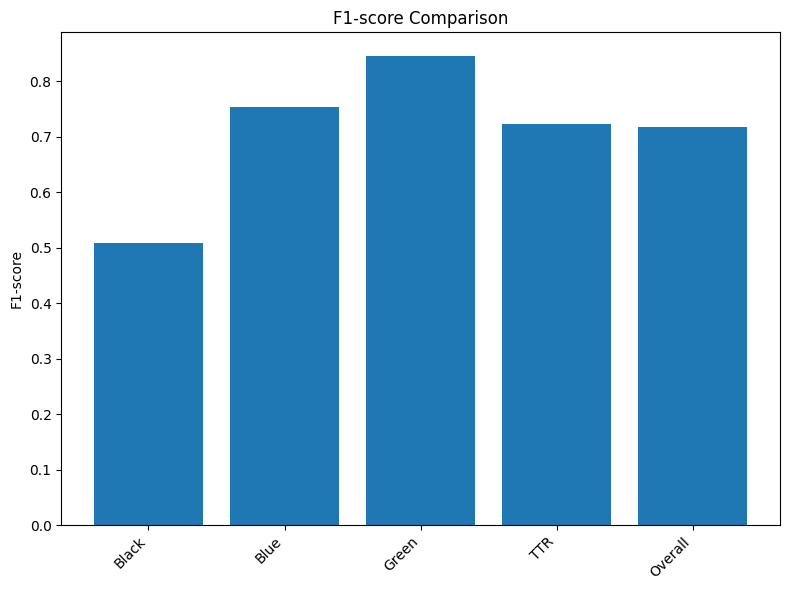

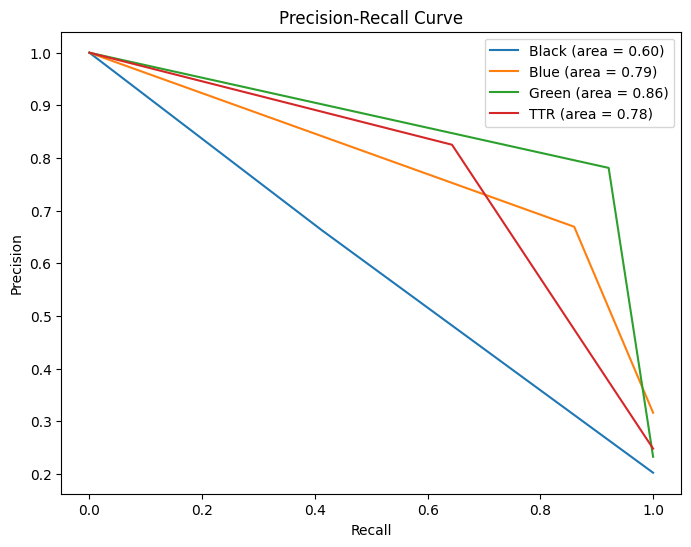

In [15]:
# Per-class metrics
class_names = dataset['test'].dataset.classes

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)

# Overall metrics
overall_precision = test_metrics['precision']
overall_recall = test_metrics['recall']
overall_f1 = test_metrics['f1']

# F1-score plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.bar(class_names + ['Overall'], list(f1) + [overall_f1])
plt.ylabel('F1-score')
plt.title('F1-score Comparison')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.tight_layout()
plt.show()

# Precision-Recall curve
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
for i in range(len(class_names)):
    precision_i, recall_i, _ = precision_recall_curve(np.array(y_true) == i, np.array(y_pred) == i)
    plt.plot(recall_i, precision_i, label=f'{class_names[i]} (area = {auc(recall_i, precision_i):.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="upper right")
plt.show()

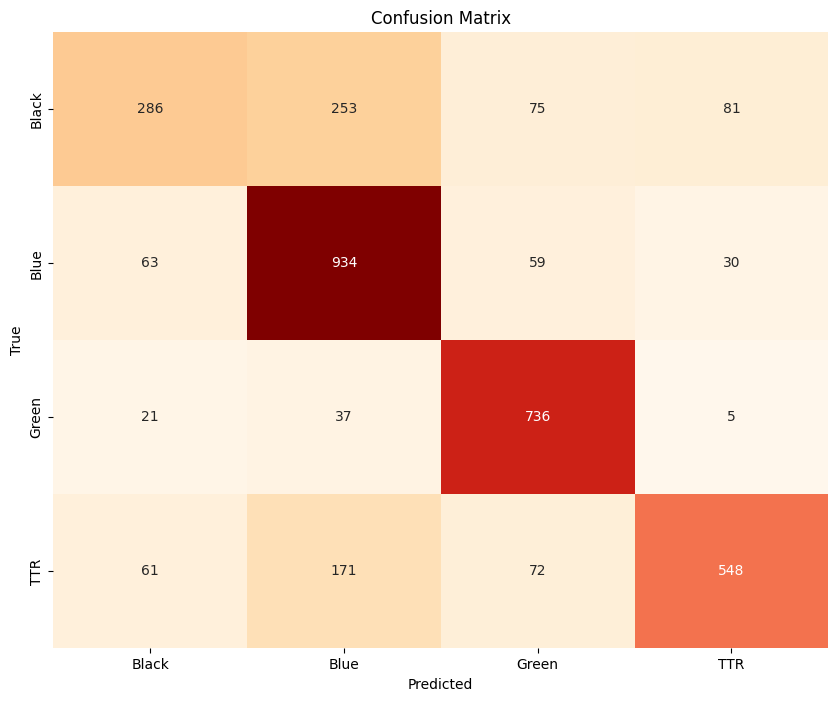

In [14]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='OrRd', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

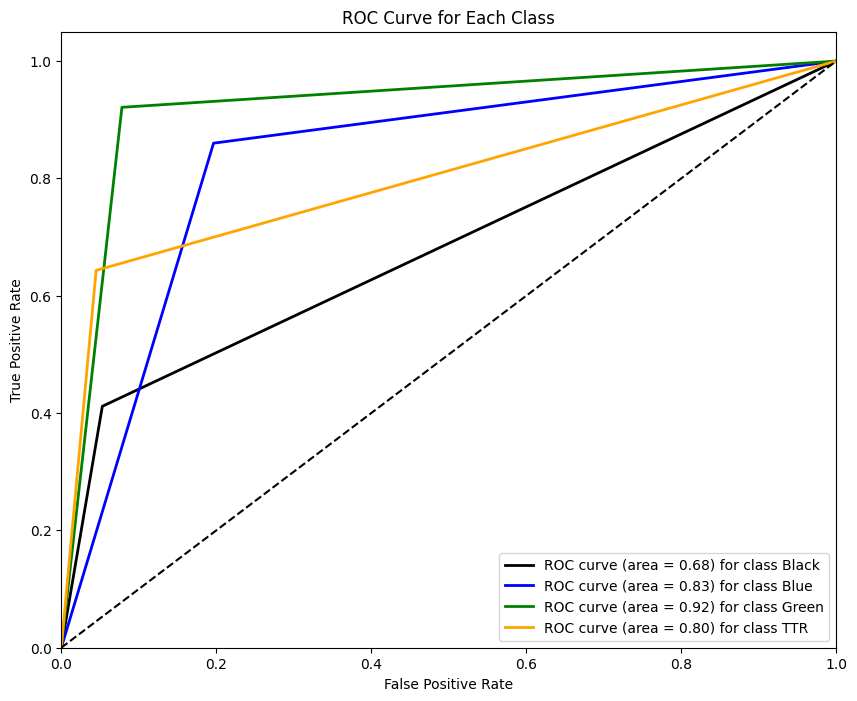

In [11]:
# ROC curve per-class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), (np.array(y_pred) == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = ['black', 'blue', 'green', 'orange']
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, color=colors[i], label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], class_names[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


# Analysis
